The purpose of this project is to access Weekly Rates of Laboratory-Confirmed RSV Hospitalizations through the CDC public API. Transform the data in preprocessing. Gather insights and then we can integrate it into private corporate data.

#create token online https://data.cdc.gov/login

Weekly RSV Hospitalizations: https://data.cdc.gov/Public-Health-Surveillance/Weekly-Rates-of-Laboratory-Confirmed-RSV-Hospitali/29hc-w46k/about_data

API Filtering: https://dev.socrata.com/docs/endpoints.html

In [1]:
#Import dependencies
import pandas as pd
import numpy as np
import requests
import json
from pandas import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
from config import token

In [2]:
#filter data to retrieve only what is needed.
ages_for_filter = ['0-17 years (Children)', '18+ years (Adults)']
filter_date_float = "$where=week_ending_date>='2023-01-01T00:00:00.000'"
row_filter = "&$limit=150000"

base_url = 'https://data.cdc.gov/resource/29hc-w46k.json'
headers = {'X-App-Token': token, 'accept': 'application/json'}

response = requests.get(base_url + '?' + filter_date_float + row_filter, headers=headers)

# Check the response status code
if response.status_code == 200:
    data = response.json()

    # Create an empty list to store DataFrames
    dfs = []

    for age_category in ages_for_filter:
        filtered_data = [item for item in data if item['age_category'] == age_category]

        # Convert the filtered data to a DataFrame
        df_age_category = pd.DataFrame(filtered_data)

        # Add a column to indicate the age category
        df_age_category['age_category'] = age_category

        # Append the DataFrame to the list
        dfs.append(df_age_category)

        # Process the filtered data as needed
        print(f"Data for age category '{age_category}': {len(filtered_data)}")

    # Concatenate all DataFrames in the list
    df = pd.concat(dfs, ignore_index=True)

    # Now, df contains all the data in a single DataFrame
    print("Combined DataFrame:")
    print(df)

    # You can save the DataFrame to a CSV file if needed
else:
    print(f"Error in fetching data: {response.status_code}")


Data for age category '0-17 years (Children)': 7800
Data for age category '18+ years (Adults)': 7800
Combined DataFrame:
             state   season week_ending_date           age_category  sex  \
0             Utah  2022-23       2023-01-07  0-17 years (Children)  All   
1             Utah  2022-23       2023-01-07  0-17 years (Children)  All   
2             Utah  2022-23       2023-01-07  0-17 years (Children)  All   
3             Utah  2022-23       2023-01-07  0-17 years (Children)  All   
4             Utah  2022-23       2023-01-07  0-17 years (Children)  All   
...            ...      ...              ...                    ...  ...   
15595      Georgia  2023-24       2024-06-08     18+ years (Adults)  All   
15596  Connecticut  2023-24       2024-06-08     18+ years (Adults)  All   
15597     Colorado  2023-24       2024-06-08     18+ years (Adults)  All   
15598   California  2023-24       2024-06-08     18+ years (Adults)  All   
15599      RSV-NET  2023-24       2024-06-0

In [3]:
df.head()

,state,season,week_ending_date,age_category,sex,race,rate,cumulative_rate
0,Utah,2022-23,2023-01-07,0-17 years (Children),All,Hispanic,12.7,266.0
1,Utah,2022-23,2023-01-07,0-17 years (Children),All,"A/PI, non-Hispanic",0.0,315.4
2,Utah,2022-23,2023-01-07,0-17 years (Children),All,"AI/AN, non-Hispanic",0.0,405.6
3,Utah,2022-23,2023-01-07,0-17 years (Children),All,"Black, non-Hispanic",0.0,369.0
4,Utah,2022-23,2023-01-07,0-17 years (Children),All,"White, non-Hispanic",3.9,209.7


In [4]:
#Asess Date Range
print(f'the min date is: {df["week_ending_date"].min()} and the max date is: {df["week_ending_date"].max()}')

the min date is: 2023-01-07 and the max date is: 2024-06-08


Check Data Output

In [5]:
df['age_category'].unique()

array(['0-17 years (Children)', '18+ years (Adults)'], dtype=object)

In [6]:
df['race'].unique()

array(['Hispanic', 'A/PI, non-Hispanic', 'AI/AN, non-Hispanic',
       'Black, non-Hispanic', 'White, non-Hispanic', 'All'], dtype=object)

In [7]:
df['sex'].unique()

array(['All', 'Female', 'Male'], dtype=object)

In [8]:
df['state'].unique()

array(['Utah', 'Tennessee', 'Oregon', 'New York', 'New Mexico',
       'Minnesota', 'Michigan', 'Maryland', 'Georgia', 'Connecticut',
       'Colorado', 'California', 'RSV-NET'], dtype=object)

In [9]:
filtered_df = df[~(df['state'] == 'RSV-NET')]
#filtered_df['state'].unique()
df = filtered_df

In [10]:
df.iloc[:,6:8].describe()

,rate,cumulative_rate
count,14400,14400
unique,264,2141
top,0.0,0.0
freq,7834,797


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14400 entries, 0 to 15598
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   state             14400 non-null  object
 1   season            14400 non-null  object
 2   week_ending_date  14400 non-null  object
 3   age_category      14400 non-null  object
 4   sex               14400 non-null  object
 5   race              14400 non-null  object
 6   rate              14400 non-null  object
 7   cumulative_rate   14400 non-null  object
dtypes: object(8)
memory usage: 1012.5+ KB


# Dealing with Data Types + Add new Columns

In [12]:
df['rate'] = pd.to_numeric(df['rate'], errors='coerce')
df['cumulative_rate'] = pd.to_numeric(df['rate'], errors='coerce')

In [13]:
#convert into a date
df['week_ending_date'] = pd.to_datetime(df['week_ending_date'], format='%Y-%m-%d')

In [14]:
#create a new month and weekday column
df['month'] = df['week_ending_date'].dt.month
df['weekday'] = df['week_ending_date'].dt.day_name()

In [15]:
#Create new column for hispanic pop vs non/all
mask = ~df['race'].str.contains('non-hispanic|all', case=False, na=False)

# Create a new column 'hispanic' and set it to 1 where the mask is True
df['hispanic'] = 0
df.loc[mask, 'hispanic'] = 1

In [16]:
df.head()

,state,season,week_ending_date,age_category,sex,race,rate,cumulative_rate,month,weekday,hispanic
0,Utah,2022-23,2023-01-07,0-17 years (Children),All,Hispanic,12.7,12.7,1,Saturday,1
1,Utah,2022-23,2023-01-07,0-17 years (Children),All,"A/PI, non-Hispanic",0.0,0.0,1,Saturday,0
2,Utah,2022-23,2023-01-07,0-17 years (Children),All,"AI/AN, non-Hispanic",0.0,0.0,1,Saturday,0
3,Utah,2022-23,2023-01-07,0-17 years (Children),All,"Black, non-Hispanic",0.0,0.0,1,Saturday,0
4,Utah,2022-23,2023-01-07,0-17 years (Children),All,"White, non-Hispanic",3.9,3.9,1,Saturday,0


In [17]:
mean_rate_by_state = df.groupby('state')['rate'].mean()
mean_rate_by_race = df.groupby('race')['rate'].mean()
print(mean_rate_by_state)
print(mean_rate_by_race)

state
California     0.786583
Colorado       2.204000
Connecticut    1.246833
Georgia        1.109333
Maryland       1.134333
Michigan       1.264833
Minnesota      1.311500
New Mexico     3.134500
New York       1.691500
Oregon         0.676250
Tennessee      0.976333
Utah           1.635417
Name: rate, dtype: float64
race
A/PI, non-Hispanic     1.043389
AI/AN, non-Hispanic    1.814056
All                    1.408574
Black, non-Hispanic    1.677111
Hispanic               1.413833
White, non-Hispanic    1.273500
Name: rate, dtype: float64


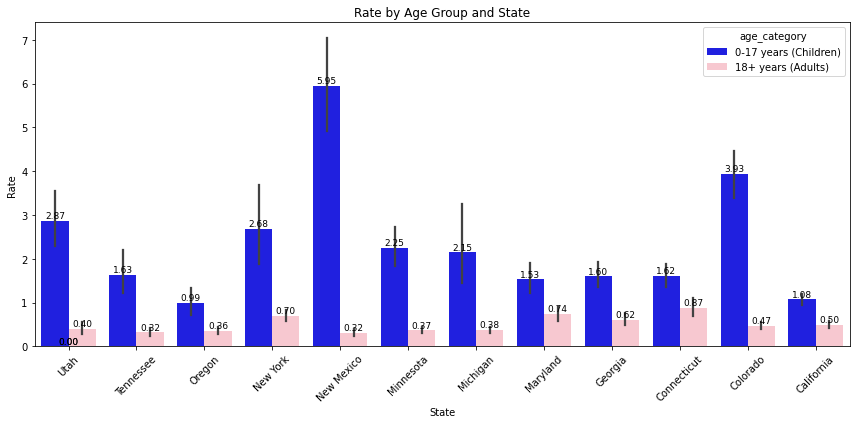

In [18]:
# Plotting
custom_palette = {'0-17 years (Children)': 'blue', '18+ years (Adults)': 'pink'}

plt.figure(figsize=(12, 6))
sns.barplot(data=filtered_df, x='state', y='rate', hue='age_category', palette=custom_palette)
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.title('Rate by Age Group and State')
plt.xlabel('State')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

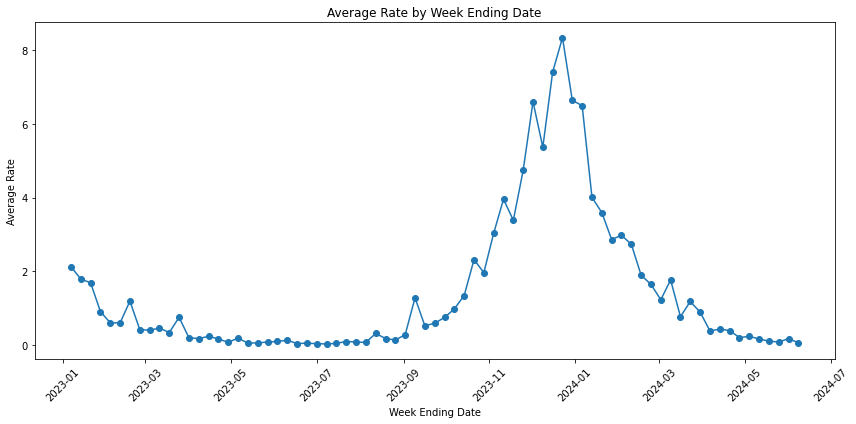

In [19]:
# Plotting
plt.figure(figsize=(12, 6))
avg_rate_by_week = df.groupby('week_ending_date')['rate'].mean()
plt.plot(avg_rate_by_week.index, avg_rate_by_week.values, marker='o', linestyle='-')

plt.title('Average Rate by Week Ending Date')
plt.xlabel('Week Ending Date')
plt.ylabel('Average Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

RSV rates are highes tin New Mexico and Colorado in the Children age group.

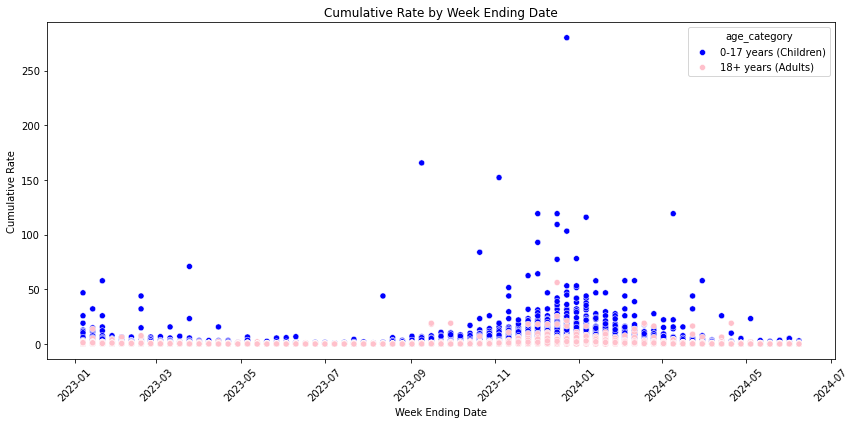

In [20]:
# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(x='week_ending_date', y='cumulative_rate', data=df, hue='age_category', palette=custom_palette)

plt.title('Cumulative Rate by Week Ending Date')
plt.xlabel('Week Ending Date')
plt.ylabel('Cumulative Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
df.to_csv('RSV_data.csv', index=False)